# Twitter discussions about trans people

In [1]:
import pandas as pd

from utils.df_imports import read_jsonl_gz

PATHS = [
    '../data/search_trans_people.jsonl.gz',
    '../data/search_transgender.jsonl.gz'
]

raw_tweet_df = pd.concat([read_jsonl_gz(path) for path in PATHS])
raw_tweet_df.drop_duplicates('id', inplace=True)

raw_tweet_df

,tweet,author,date,id
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408
...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010


## Preliminary Data Cleaning Steps

In [2]:
tweet_df = raw_tweet_df
#tweet_df = tweet_df[~tweet_df['tweet'].str.startswith('RT @')]  # remove retweets?

## N-gram hits

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


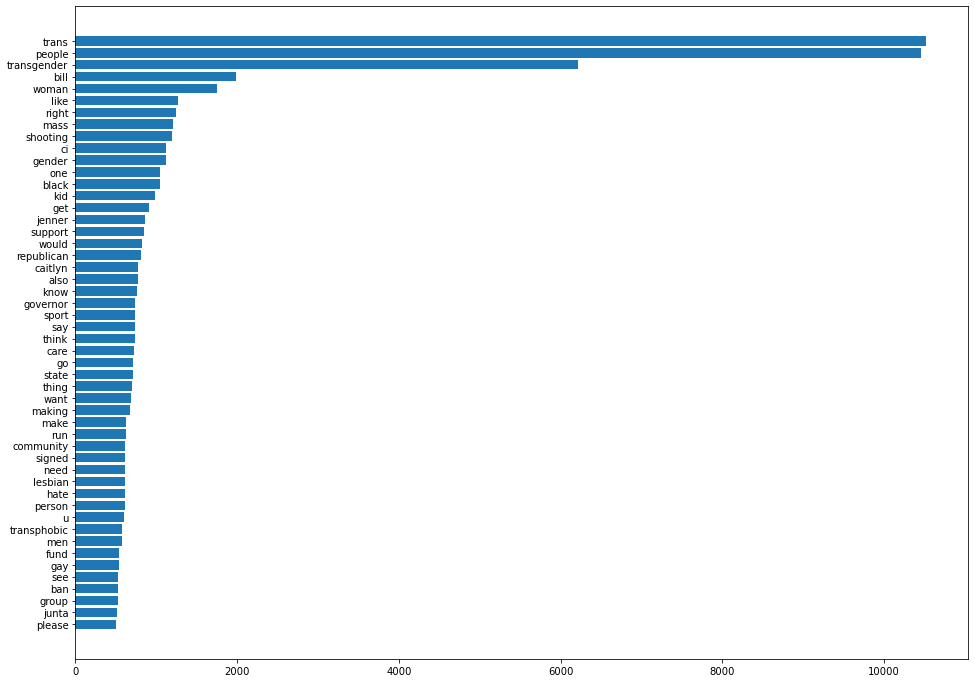

In [3]:
from utils.tokens import build_stopword_set, plot_ngrams
import matplotlib.pyplot as plt

stop = build_stopword_set()

_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=1)
plt.show()

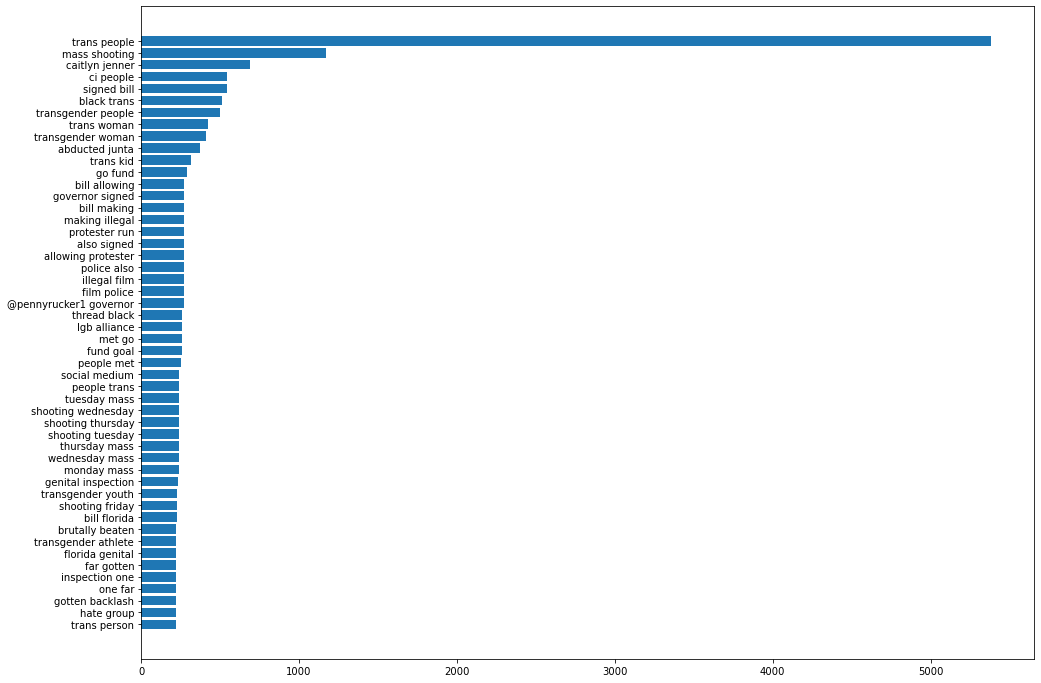

In [4]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=2)
plt.show()

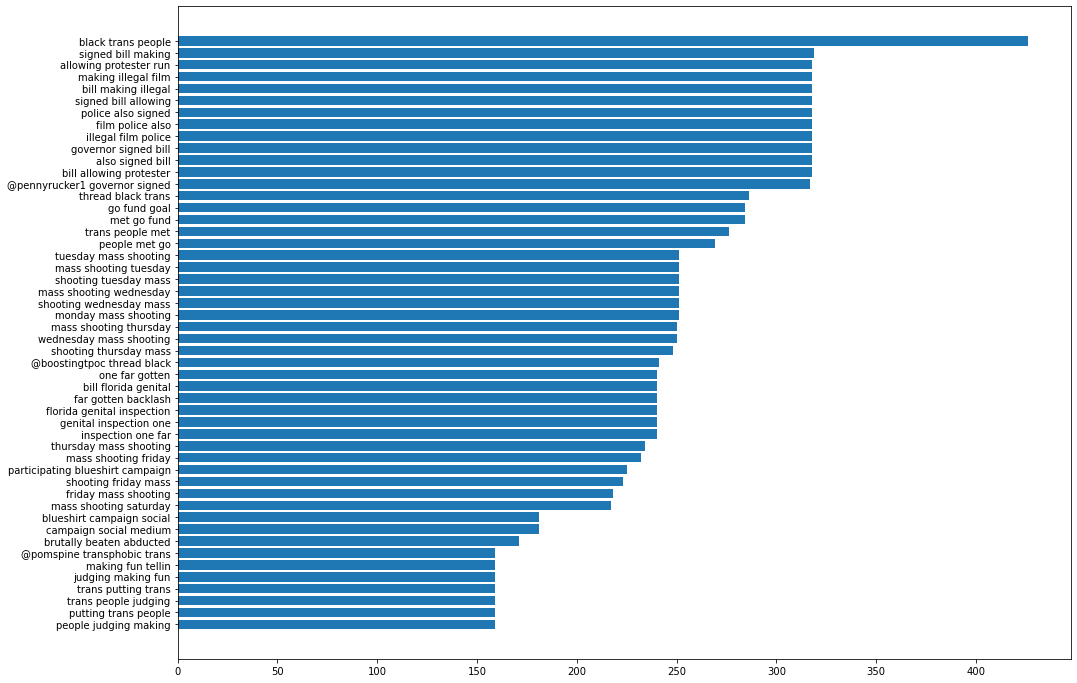

In [5]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=3)
plt.show()

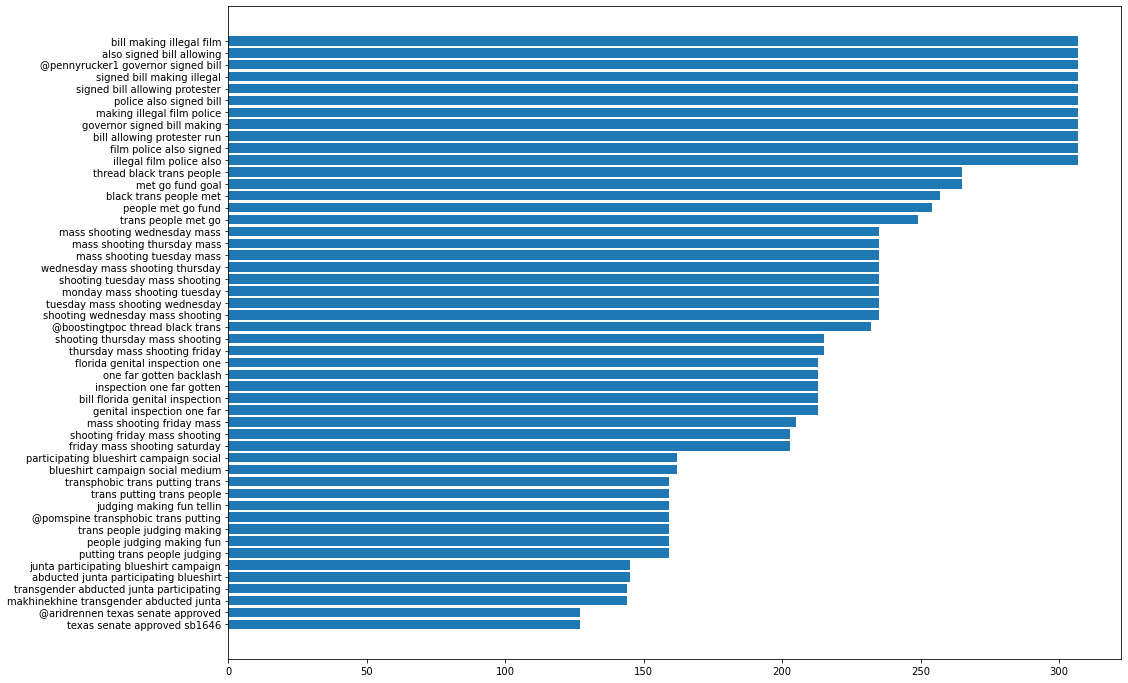

In [6]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=4)
plt.show()

### Interesting notes

- There is mention of the Myanmar coup, which abducted and attacked Mingalar Taungnyunt, a trans woman protestor (`transgender abducted junta` with 270 hits)
- A mass shooting on Thursday performed by a trans man (250 ish hits)
- Caitlyn Jenner running for governor (`caitlyn jenner` with ~750 hits)
- BLM riots?
- `@boostingtpoc thread black` trans people who have not met their go fund me goals
- Various bills where republicans attack trans people in women's sports
    - `florida genital inspection` with 250 hits
    - `texas senate approved sb1646` with 150 hits
    - Non-trans, but also Republican bills get included in these mentions (i.e. illegal to film police, the running over protestors bill)
- Something about judging trans people (150 hits?)

## LDA Time